## Analysis and Modeling of Exercise Images with Pose Estimation from MediaPipe and OpenCV

This notebook will delve into the analysis and modeling of various exercise images using different python libraries, including mediapipe, openCV, and pandas.

In [38]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

#read data and take a look
df = pd.read_csv('imagePoses.csv')
df.head()


,imageName,base64encoded,imageWidth,imageHeight,poseLandmarks,excercise
0,full-body-person-doing-pushup0.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQERMT...,183,275,"['x: 0.7909860014915466,y: 0.2797396183013916,...",pushup
1,full-body-person-doing-pushup1.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgW...,244,206,"['x: 0.5600898265838623,y: 0.5534414052963257,...",pushup
2,full-body-person-doing-pushup10.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRUW...,167,302,"['x: 0.4751896560192108,y: 0.4453135132789612,...",pushup
3,full-body-person-doing-pushup100.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgW...,183,275,"['x: 0.4743218421936035,y: 0.5276893377304077,...",pushup
4,full-body-person-doing-pushup101.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxIREhUT...,225,225,NaN,pushup


### Here is an example of the images used:

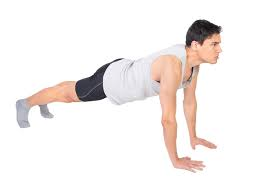

In [69]:
from base64 import b64decode
from IPython import display

#decode from base64
imgB64 = df['base64encoded'][0][2:]
imgStr = b64decode(imgB64)
display.Image(imgStr)

### An example of the image with the pose estimation:

In [79]:
#function to clean landmarks
def cleanPLs(lm):
    lm = lm.replace("'", '').replace('"', '').strip('][').split(',')
    while ('' in lm):
        lm.remove('')
    cleanLM = []
    for i in range(0, len(lm) - 4, 4):
        lm[i] = lm[i].strip()
        cleanLM.append([lm[i], lm[i+1], lm[i+2], lm[i+3]])
    return cleanLM

cleanLandmarks = cleanPLs(df['poseLandmarks'][0])
cleanLandmarks[:5]

[['x: 0.7909860014915466',
  'y: 0.2797396183013916',
  'z: -0.7337014675140381',
  'visibility: 0.9999721050262451'],
 ['x: 0.786137580871582',
  'y: 0.24491778016090393',
  'z: -0.699945330619812',
  'visibility: 0.999929666519165'],
 ['x: 0.7857223749160767',
  'y: 0.2434578835964203',
  'z: -0.6998971700668335',
  'visibility: 0.9999117851257324'],
 ['x: 0.7850363254547119',
  'y: 0.2417711317539215',
  'z: -0.7000457644462585',
  'visibility: 0.9999598264694214'],
 ['x: 0.7788354158401489',
  'y: 0.24451936781406403',
  'z: -0.7689036726951599',
  'visibility: 0.9999768733978271']]

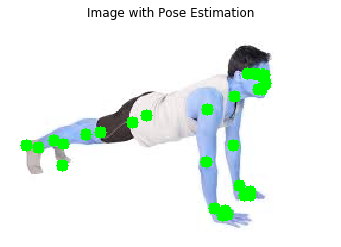

In [84]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

#convert from bytestring to cv image
nparr = np.fromstring(imgStr, np.uint8)
imgPose = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

#loop thru landmarks
for lm in cleanLandmarks:
    h, w, c = imgPose.shape
    #strip digits and convert to x, y floats
    x = float(lm[0].replace('x: ', ''))
    y = float(lm[1].replace('y: ', ''))
    #multiply and create shapes on image
    cx, cy = int(x*w), int(y*h)
    cv2.circle(imgPose, (cx, cy), 5, (0,0,255), cv2.FILLED)

plt.imshow(imgPose)
plt.title('Image with Pose Estimation')
plt.axis('off')
plt.show()